In [1]:
import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import RLAgent

# Other utils functions
from reinforcetrader.utils.rewards import evaluate_reward_function

# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

2025-08-25 22:10:24.638885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Pre-processing and Feature Building

In [12]:
# Get DJI raw data using Yahoo Finance API
data_loader = RawDataLoader(start_date='1999-08-01', end_date='2025-08-11', index='DJI')

# Download or load from cache the data
raw_data = data_loader.get_hist_prices()

# Inspect the raw DJI close and volume data
display_df(raw_data)

[*********************100%***********************]  30 of 30 completed


Dropped 2 tickers. 28 tickers left.
Tickers dropped: CRM, V
Data saved to data/raw/DJI_tickers_data_1999-08-01_2025-08-11.csv


Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT
Price,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-08-02,0.418405,27.008614,2.350000,26.759926,29.387829,15.095906,20.226343,17.283487,20.469776,43.912930,24.448803,34.258575,60.700550,23.529583,24.693939,14.641419,22.914881,18.153021,25.379461,25.952599,4.699342,0.038803,22.806913,6.088423,16.810499,6.075972,17.081629,9.014958,0.435292,27.437322,2.553125,27.930111,29.828847,15.192572,20.942139,17.532085,20.987403,45.136374,25.159241,34.557922,62.562533,23.785513,24.772832,14.915660,22.948382,18.356559,25.873867,26.602848,4.910285,0.038922,23.091604,6.158245,17.071633,6.217131,17.213026,9.254294,0.416529,26.279810,2.348438,26.708490,28.866626,15.047574,20.042281,17.224297,20.469776,43.607068,24.301816,34.158793,60.483320,23.417614,24.240295,14.626184,22.211354,17.733225,25.285289,25.818724,4.664185,0.038206,22.727833,6.032566,16.353515,5.990049,16.818835,8.935180,0.417467,26.279810,2.459375,27.158559,29.107181,15.112017,20.185441,17.295325,20.752118,44.917902,24.742777,34.358360,61.569475,23.529583,24.279744,14.763304,22.244855,17.898599,25.332374,26.220348,4.863409,0.038444,22.727833,6.032566,16.451440,5.990049,16.884533,9.001662,362443200,14186400,339356000,8751857,2641100,2118000,28405600,1705000,3526812,566400,4064100,1146355,4775095,3559800,6278850,5161000,2372700,2258287,3458295,48050600,14422400,313344000,4158800,581400,377100,3470400,3194070,16741800
1999-08-03,0.414653,26.279816,2.371875,26.065540,30.189682,14.918696,20.001381,17.614952,20.187431,42.514687,23.762867,33.826176,59.272991,24.105417,24.871447,14.824239,22.713873,18.343838,25.238214,25.933460,4.617310,0.037848,23.708441,6.046531,16.777863,5.627945,16.818838,8.921882,0.431070,27.158668,2.425000,27.055698,30.189682,15.192582,20.471761,17.626790,20.658002,43.912909,24.595791,34.491390,61.134972,24.313360,24.910893,14.900417,22.948382,18.394722,25.661990,26.335085,4.839972,0.038803,23.850786,6.102389,16.973713,5.891851,17.180180,9.121328,0.402457,25.786801,2.240625,25.924090,29.508109,14.805920,19.715063,17.259812,19.905089,42.470992,23.713870,33.593351,58.683365,23.817496,24.615039,14.656647,22.412361,18.178462,25.096957,25.818710,4.611450,0.037489,22.854368,5.990674,16.614654,5.609533,16.769565,8.788917,0.425910,27.072926,2.425000,26.901387,29.508109,15.095916,20.451310,17.567600,20.469773,43.912909,24.399809,34.258565,60.948772,24.025439,24.693934,14.656647,22.780875,18.292953,25.544274,26.277710,4.793095,0.038803,22.870184,6.060496,16.745221,5.891851,17.048783,9.054845,368379200,11616400,582780000,8694619,2854000,2275600,32937000,2072200,7458388,837700,585

In [13]:
# Instantiate Feature Builder to Build relevant features for state space
feature_builder = FeatureBuilder(hist_prices=raw_data)

# Build the features
feature_builder.build_features()
features_data = feature_builder.get_features()

# Inspect the features
display_df(features_data, rows=5)

Building ticker features: 100%|█████████████████████████████████████| 28/28 [00:02<00:00,  9.40it/s]


Features data saved to data/processed/DJI_tickers_features_2000-03-06_2025-08-08.csv


# State Representation

In [4]:
state_loader = EpisodeStateLoader(features_data, 'configs/episodes.json')

trade index: 8


In [5]:
state_loader.get_state_matrix('train', 1, 'AAPL', 2, 4)

array([[ 0.38463455,  0.5897253 ,  0.02564011,  0.        ,  0.00802285,
         0.04343423,  0.04222202,  0.8291178 ,  0.2665844 ,  0.2850386 ,
         0.        ,  0.5313614 ],
       [ 0.38463455,  0.5897253 ,  0.02564011,  0.        ,  0.00802285,
         0.04343423,  0.04222202,  0.8291178 ,  0.2665844 ,  0.2850386 ,
         0.        ,  0.5313614 ],
       [-0.6128125 ,  0.01113928,  0.37604818,  0.        , -0.01009861,
         0.03409885,  0.04086553,  0.7230421 ,  0.2711807 ,  0.19796352,
         0.        ,  0.70516175],
       [-0.6377509 ,  0.3367397 ,  0.02550943,  0.        , -0.05781392,
         0.01272241,  0.03407596,  0.4237374 ,  0.26780808, -0.02859681,
         0.34759647,  1.2002095 ]], dtype=float32)

In [6]:
state_loader.get_state_OHLCV('train', 1, 'AAPL', 1)

array([1.0460141e+00, 1.0464830e+00, 1.0043843e+00, 1.0202154e+00,
       2.3983680e+08], dtype=float32)

# Deep Q-Network and RL Agent

In [5]:
# Init the RL agent and DQN Model
window_size = 26
num_motif_fetures = 3
num_context_features = 9
agent = RLAgent(window_size=window_size, num_features=(num_motif_fetures, num_context_features))

I0000 00:00:1756159734.464002   82914 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


[*********************100%***********************]  1 of 1 completed

Dropped 0 tickers. 1 tickers left.



/home/shiv/projects/ReinforceTrader/reinforcetrader/utils/rewards.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(data.index, rotation=45)


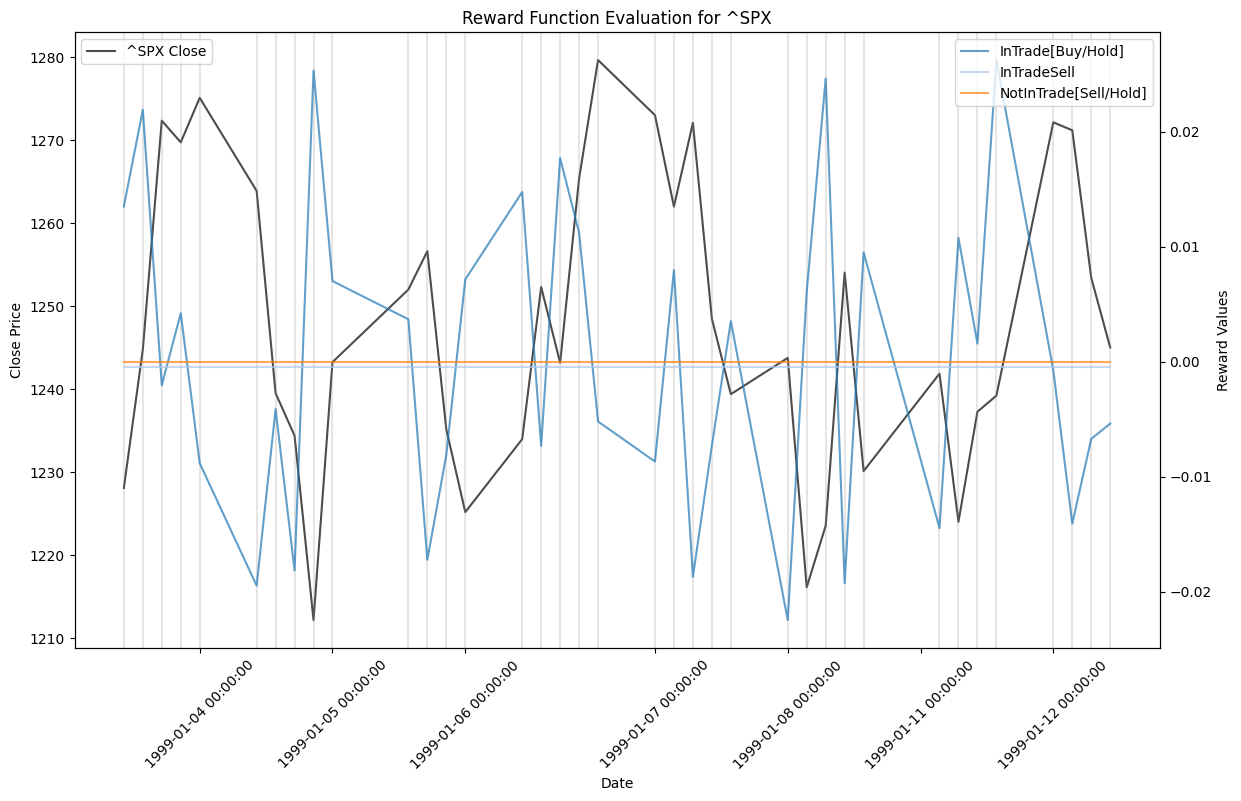

In [6]:
rewards = evaluate_reward_function(ticker='^SPX', start_date='1999-01-01', end_date='1999-03-01', reward_fn=agent.calculate_reward)

# Reward Function and Evaluation

In [7]:
training_config = {
    'batch_size': 256,
    'val_group_size': 5,
    'replay_start_size': 5000,
    'train_interval': 1,
    'gradient_step_repeat': 2,
    'model_dir': 'model_checkpoints/',
    'plots_dir': 'plots/validation/'
}

Training episode 1:   0%|                                                    | 0/28 [00:00<?, ?it/s]2025-08-25 15:09:00.217311: I external/local_xla/xla/service/service.cc:163] XLA service 0x79744c004f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-25 15:09:00.217343: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-08-25 15:09:00.253210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-25 15:09:00.338069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-25 15:09:00.372745: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative

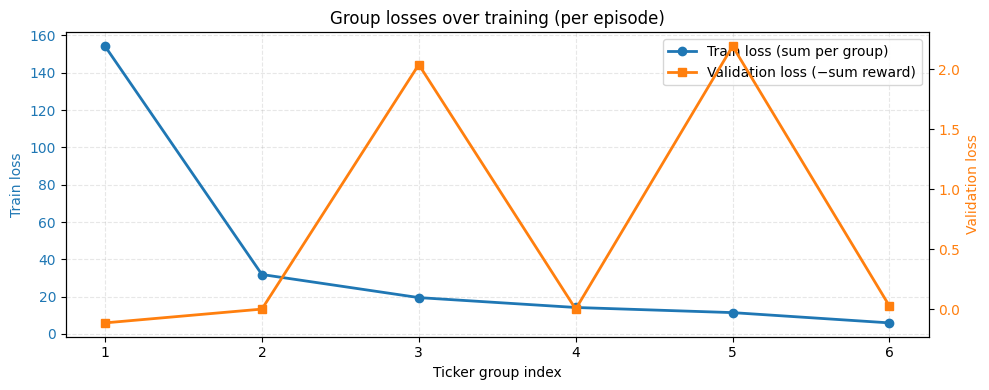

Training episode 2: 100%|███████████████████████████████████████████| 28/28 [21:10<00:00, 45.39s/it]


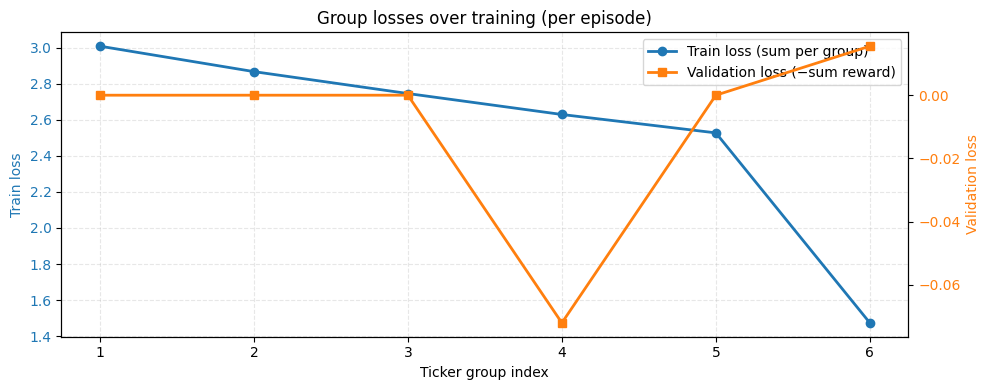

Training episode 3:  57%|██████████████████████▊                 | 16/28 [1:17:10<58:33, 292.81s/it]

In [ ]:
episode_list = np.arange(1, 8)
agent.train(state_loader, episode_list, training_config)